# Semantic Trajectory Clustering for 'run'

In [17]:
import torch
import numpy as np
import pandas as pd
from transformers import BertTokenizer, BertModel
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from tqdm import tqdm
from umap import UMAP
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


In [18]:
sentences = [
    # Descriptive
    "She likes to run early in the morning before work.",
    "The machine will run continuously for 48 hours.",
    "The river runs along the eastern border.",
    "This road runs all the way to the coast.",
    "Let the engine run for five minutes before starting.",
    "The ink began to run in the rain.",
    "He ran into trouble with the tax authorities.",
    "They ran diagnostics to isolate the error.",
    "The software update runs automatically.",
    "The mountain stream runs fast in spring.",
    "The contract runs until the end of the fiscal year.",
    "He was caught in a run of bad luck at the poker table.",

    # Evaluative
    "The show has had a good run but it's time to end.",
    "The joke is starting to run thin.",
    "That joke ran a bit too long for my taste.",
    "He let his imagination run wild.",
    "Don't let your temper run away with you.",
    "The campaign is running out of steam.",
    "Run the idea by me one more time.",
    "This film had a limited theatrical run.",
    "She ran the numbers twice before presenting them.",
    "That rumor ran rampant on social media.",
    "He’s running behind schedule again.",
    "The play ran for three consecutive seasons.",

    # Narrative
    "She had to run to catch the last train home.",
    "The children ran screaming through the sprinkler.",
    "We saw a deer run across the highway at dusk.",
    "The suspect tried to run from the scene.",
    "The car ran out of gas in the middle of nowhere.",
    "She ran her fingers along the dusty shelf.",
    "He ran his hand over the sculpture's surface.",
    "The marathon runner collapsed after a grueling 26-mile run.",
    "He used to run track in college.",
    "The team went on a five-game winning run.",
    "His speech ran over the allotted time.",
    "We did a test run before the final performance.",

    # Performative
    "Run for your life!",
    "Let’s run through the list one more time.",
    "She decided to run the experiment again with new variables.",
    "They run a tight ship in that department.",
    "They run a small family-owned bakery downtown.",
    "They run tests on the samples before publishing results.",
    "She’s running for president of the student council.",
    "He decided to run for office in the next election.",
    "They’re running a sale on electronics this weekend.",
    "The rumor began to run through the school like wildfire.",
    "She ran the household with precision and calm.",
    "He let the story run its course."
]


In [19]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertModel.from_pretrained("bert-base-uncased", output_hidden_states=True)
model.eval()

trajectories = []
valid_sentences = []

print("🔍 Matching token: 'run'")

for sent in tqdm(sentences):
    inputs = tokenizer(sent, return_tensors="pt")
    with torch.no_grad():
        outputs = model(**inputs)
    input_ids = inputs["input_ids"][0]
    tokens = tokenizer.convert_ids_to_tokens(input_ids)
    
    # Show tokenized version
    print(f"🧾 Sentence: {sent}")
    print(f"🔤 Tokens: {tokens}")
    
    # More robust matching: match substrings like 'run', 'running', '##run'
    match_indices = [i for i, tok in enumerate(tokens) if "run" in tok.lower()]
    
    if not match_indices:
        print("⚠️ No 'run' token found — skipping.")
        continue

    idx = match_indices[0]  # just first match
    layers = outputs.hidden_states
    curve = torch.stack([layer[0, idx] for layer in layers])  # (13, 768)

    # Take only the last 12 layers (excluding embedding)
    curve = curve[-12:]

    if curve.shape == (12, 768):
        trajectories.append(curve.numpy())
        valid_sentences.append(sent)
    else:
        print("❌ Unexpected shape — skipping.")

print(f"\n✅ Extracted {len(trajectories)} valid trajectories.")

🔍 Matching token: 'run'


  2%|██▎                                                                                                             | 1/48 [00:00<00:08,  5.55it/s]

🧾 Sentence: She likes to run early in the morning before work.
🔤 Tokens: ['[CLS]', 'she', 'likes', 'to', 'run', 'early', 'in', 'the', 'morning', 'before', 'work', '.', '[SEP]']


  4%|████▋                                                                                                           | 2/48 [00:00<00:08,  5.32it/s]

🧾 Sentence: The machine will run continuously for 48 hours.
🔤 Tokens: ['[CLS]', 'the', 'machine', 'will', 'run', 'continuously', 'for', '48', 'hours', '.', '[SEP]']


  6%|███████                                                                                                         | 3/48 [00:00<00:07,  6.08it/s]

🧾 Sentence: The river runs along the eastern border.
🔤 Tokens: ['[CLS]', 'the', 'river', 'runs', 'along', 'the', 'eastern', 'border', '.', '[SEP]']


  8%|█████████▎                                                                                                      | 4/48 [00:00<00:07,  5.92it/s]

🧾 Sentence: This road runs all the way to the coast.
🔤 Tokens: ['[CLS]', 'this', 'road', 'runs', 'all', 'the', 'way', 'to', 'the', 'coast', '.', '[SEP]']


 10%|███████████▋                                                                                                    | 5/48 [00:00<00:07,  5.84it/s]

🧾 Sentence: Let the engine run for five minutes before starting.
🔤 Tokens: ['[CLS]', 'let', 'the', 'engine', 'run', 'for', 'five', 'minutes', 'before', 'starting', '.', '[SEP]']


 12%|██████████████                                                                                                  | 6/48 [00:01<00:07,  5.59it/s]

🧾 Sentence: The ink began to run in the rain.
🔤 Tokens: ['[CLS]', 'the', 'ink', 'began', 'to', 'run', 'in', 'the', 'rain', '.', '[SEP]']


 15%|████████████████▎                                                                                               | 7/48 [00:01<00:07,  5.68it/s]

🧾 Sentence: He ran into trouble with the tax authorities.
🔤 Tokens: ['[CLS]', 'he', 'ran', 'into', 'trouble', 'with', 'the', 'tax', 'authorities', '.', '[SEP]']
⚠️ No 'run' token found — skipping.


 17%|██████████████████▋                                                                                             | 8/48 [00:01<00:06,  5.76it/s]

🧾 Sentence: They ran diagnostics to isolate the error.
🔤 Tokens: ['[CLS]', 'they', 'ran', 'diagnostic', '##s', 'to', 'isolate', 'the', 'error', '.', '[SEP]']
⚠️ No 'run' token found — skipping.


 19%|█████████████████████                                                                                           | 9/48 [00:01<00:06,  5.95it/s]

🧾 Sentence: The software update runs automatically.
🔤 Tokens: ['[CLS]', 'the', 'software', 'update', 'runs', 'automatically', '.', '[SEP]']


 21%|███████████████████████▏                                                                                       | 10/48 [00:01<00:06,  6.07it/s]

🧾 Sentence: The mountain stream runs fast in spring.
🔤 Tokens: ['[CLS]', 'the', 'mountain', 'stream', 'runs', 'fast', 'in', 'spring', '.', '[SEP]']


 23%|█████████████████████████▍                                                                                     | 11/48 [00:01<00:06,  5.80it/s]

🧾 Sentence: The contract runs until the end of the fiscal year.
🔤 Tokens: ['[CLS]', 'the', 'contract', 'runs', 'until', 'the', 'end', 'of', 'the', 'fiscal', 'year', '.', '[SEP]']


 25%|███████████████████████████▊                                                                                   | 12/48 [00:02<00:06,  5.85it/s]

🧾 Sentence: He was caught in a run of bad luck at the poker table.
🔤 Tokens: ['[CLS]', 'he', 'was', 'caught', 'in', 'a', 'run', 'of', 'bad', 'luck', 'at', 'the', 'poker', 'table', '.', '[SEP]']


 27%|██████████████████████████████                                                                                 | 13/48 [00:02<00:05,  5.94it/s]

🧾 Sentence: The show has had a good run but it's time to end.
🔤 Tokens: ['[CLS]', 'the', 'show', 'has', 'had', 'a', 'good', 'run', 'but', 'it', "'", 's', 'time', 'to', 'end', '.', '[SEP]']


 29%|████████████████████████████████▍                                                                              | 14/48 [00:02<00:05,  6.02it/s]

🧾 Sentence: The joke is starting to run thin.
🔤 Tokens: ['[CLS]', 'the', 'joke', 'is', 'starting', 'to', 'run', 'thin', '.', '[SEP]']


 31%|██████████████████████████████████▋                                                                            | 15/48 [00:02<00:05,  6.04it/s]

🧾 Sentence: That joke ran a bit too long for my taste.
🔤 Tokens: ['[CLS]', 'that', 'joke', 'ran', 'a', 'bit', 'too', 'long', 'for', 'my', 'taste', '.', '[SEP]']
⚠️ No 'run' token found — skipping.


 33%|█████████████████████████████████████                                                                          | 16/48 [00:02<00:05,  6.17it/s]

🧾 Sentence: He let his imagination run wild.
🔤 Tokens: ['[CLS]', 'he', 'let', 'his', 'imagination', 'run', 'wild', '.', '[SEP]']


 35%|███████████████████████████████████████▎                                                                       | 17/48 [00:02<00:05,  5.88it/s]

🧾 Sentence: Don't let your temper run away with you.
🔤 Tokens: ['[CLS]', 'don', "'", 't', 'let', 'your', 'temper', 'run', 'away', 'with', 'you', '.', '[SEP]']


 38%|█████████████████████████████████████████▋                                                                     | 18/48 [00:03<00:05,  5.82it/s]

🧾 Sentence: The campaign is running out of steam.
🔤 Tokens: ['[CLS]', 'the', 'campaign', 'is', 'running', 'out', 'of', 'steam', '.', '[SEP]']


 40%|███████████████████████████████████████████▉                                                                   | 19/48 [00:03<00:04,  5.98it/s]

🧾 Sentence: Run the idea by me one more time.
🔤 Tokens: ['[CLS]', 'run', 'the', 'idea', 'by', 'me', 'one', 'more', 'time', '.', '[SEP]']


 42%|██████████████████████████████████████████████▎                                                                | 20/48 [00:03<00:04,  5.71it/s]

🧾 Sentence: This film had a limited theatrical run.
🔤 Tokens: ['[CLS]', 'this', 'film', 'had', 'a', 'limited', 'theatrical', 'run', '.', '[SEP]']


 46%|██████████████████████████████████████████████████▉                                                            | 22/48 [00:03<00:04,  5.43it/s]

🧾 Sentence: She ran the numbers twice before presenting them.
🔤 Tokens: ['[CLS]', 'she', 'ran', 'the', 'numbers', 'twice', 'before', 'presenting', 'them', '.', '[SEP]']
⚠️ No 'run' token found — skipping.
🧾 Sentence: That rumor ran rampant on social media.
🔤 Tokens: ['[CLS]', 'that', 'rumor', 'ran', 'rampant', 'on', 'social', 'media', '.', '[SEP]']
⚠️ No 'run' token found — skipping.


 50%|███████████████████████████████████████████████████████▌                                                       | 24/48 [00:04<00:04,  5.37it/s]

🧾 Sentence: He’s running behind schedule again.
🔤 Tokens: ['[CLS]', 'he', '’', 's', 'running', 'behind', 'schedule', 'again', '.', '[SEP]']
🧾 Sentence: The play ran for three consecutive seasons.
🔤 Tokens: ['[CLS]', 'the', 'play', 'ran', 'for', 'three', 'consecutive', 'seasons', '.', '[SEP]']
⚠️ No 'run' token found — skipping.


 54%|████████████████████████████████████████████████████████████                                                   | 26/48 [00:04<00:04,  5.25it/s]

🧾 Sentence: She had to run to catch the last train home.
🔤 Tokens: ['[CLS]', 'she', 'had', 'to', 'run', 'to', 'catch', 'the', 'last', 'train', 'home', '.', '[SEP]']
🧾 Sentence: The children ran screaming through the sprinkler.
🔤 Tokens: ['[CLS]', 'the', 'children', 'ran', 'screaming', 'through', 'the', 'sp', '##rin', '##kle', '##r', '.', '[SEP]']
⚠️ No 'run' token found — skipping.


 58%|████████████████████████████████████████████████████████████████▊                                              | 28/48 [00:04<00:03,  6.12it/s]

🧾 Sentence: We saw a deer run across the highway at dusk.
🔤 Tokens: ['[CLS]', 'we', 'saw', 'a', 'deer', 'run', 'across', 'the', 'highway', 'at', 'dusk', '.', '[SEP]']
🧾 Sentence: The suspect tried to run from the scene.
🔤 Tokens: ['[CLS]', 'the', 'suspect', 'tried', 'to', 'run', 'from', 'the', 'scene', '.', '[SEP]']


 62%|█████████████████████████████████████████████████████████████████████▍                                         | 30/48 [00:05<00:02,  7.30it/s]

🧾 Sentence: The car ran out of gas in the middle of nowhere.
🔤 Tokens: ['[CLS]', 'the', 'car', 'ran', 'out', 'of', 'gas', 'in', 'the', 'middle', 'of', 'nowhere', '.', '[SEP]']
⚠️ No 'run' token found — skipping.
🧾 Sentence: She ran her fingers along the dusty shelf.
🔤 Tokens: ['[CLS]', 'she', 'ran', 'her', 'fingers', 'along', 'the', 'dusty', 'shelf', '.', '[SEP]']
⚠️ No 'run' token found — skipping.


 67%|██████████████████████████████████████████████████████████████████████████                                     | 32/48 [00:05<00:02,  7.94it/s]

🧾 Sentence: He ran his hand over the sculpture's surface.
🔤 Tokens: ['[CLS]', 'he', 'ran', 'his', 'hand', 'over', 'the', 'sculpture', "'", 's', 'surface', '.', '[SEP]']
⚠️ No 'run' token found — skipping.
🧾 Sentence: The marathon runner collapsed after a grueling 26-mile run.
🔤 Tokens: ['[CLS]', 'the', 'marathon', 'runner', 'collapsed', 'after', 'a', 'gr', '##uel', '##ing', '26', '-', 'mile', 'run', '.', '[SEP]']


 73%|████████████████████████████████████████████████████████████████████████████████▉                              | 35/48 [00:05<00:01,  9.25it/s]

🧾 Sentence: He used to run track in college.
🔤 Tokens: ['[CLS]', 'he', 'used', 'to', 'run', 'track', 'in', 'college', '.', '[SEP]']
🧾 Sentence: The team went on a five-game winning run.
🔤 Tokens: ['[CLS]', 'the', 'team', 'went', 'on', 'a', 'five', '-', 'game', 'winning', 'run', '.', '[SEP]']
🧾 Sentence: His speech ran over the allotted time.
🔤 Tokens: ['[CLS]', 'his', 'speech', 'ran', 'over', 'the', 'allotted', 'time', '.', '[SEP]']
⚠️ No 'run' token found — skipping.


 77%|█████████████████████████████████████████████████████████████████████████████████████▌                         | 37/48 [00:05<00:01, 10.19it/s]

🧾 Sentence: We did a test run before the final performance.
🔤 Tokens: ['[CLS]', 'we', 'did', 'a', 'test', 'run', 'before', 'the', 'final', 'performance', '.', '[SEP]']
🧾 Sentence: Run for your life!
🔤 Tokens: ['[CLS]', 'run', 'for', 'your', 'life', '!', '[SEP]']


 81%|██████████████████████████████████████████████████████████████████████████████████████████▏                    | 39/48 [00:05<00:00, 10.25it/s]

🧾 Sentence: Let’s run through the list one more time.
🔤 Tokens: ['[CLS]', 'let', '’', 's', 'run', 'through', 'the', 'list', 'one', 'more', 'time', '.', '[SEP]']
🧾 Sentence: She decided to run the experiment again with new variables.
🔤 Tokens: ['[CLS]', 'she', 'decided', 'to', 'run', 'the', 'experiment', 'again', 'with', 'new', 'variables', '.', '[SEP]']
🧾 Sentence: They run a tight ship in that department.
🔤 Tokens: ['[CLS]', 'they', 'run', 'a', 'tight', 'ship', 'in', 'that', 'department', '.', '[SEP]']


 85%|██████████████████████████████████████████████████████████████████████████████████████████████▊                | 41/48 [00:06<00:00, 10.42it/s]

🧾 Sentence: They run a small family-owned bakery downtown.
🔤 Tokens: ['[CLS]', 'they', 'run', 'a', 'small', 'family', '-', 'owned', 'bakery', 'downtown', '.', '[SEP]']
🧾 Sentence: They run tests on the samples before publishing results.
🔤 Tokens: ['[CLS]', 'they', 'run', 'tests', 'on', 'the', 'samples', 'before', 'publishing', 'results', '.', '[SEP]']


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 44/48 [00:06<00:00,  9.84it/s]

🧾 Sentence: She’s running for president of the student council.
🔤 Tokens: ['[CLS]', 'she', '’', 's', 'running', 'for', 'president', 'of', 'the', 'student', 'council', '.', '[SEP]']
🧾 Sentence: He decided to run for office in the next election.
🔤 Tokens: ['[CLS]', 'he', 'decided', 'to', 'run', 'for', 'office', 'in', 'the', 'next', 'election', '.', '[SEP]']


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 46/48 [00:06<00:00, 10.51it/s]

🧾 Sentence: They’re running a sale on electronics this weekend.
🔤 Tokens: ['[CLS]', 'they', '’', 're', 'running', 'a', 'sale', 'on', 'electronics', 'this', 'weekend', '.', '[SEP]']
🧾 Sentence: The rumor began to run through the school like wildfire.
🔤 Tokens: ['[CLS]', 'the', 'rumor', 'began', 'to', 'run', 'through', 'the', 'school', 'like', 'wild', '##fire', '.', '[SEP]']
🧾 Sentence: She ran the household with precision and calm.
🔤 Tokens: ['[CLS]', 'she', 'ran', 'the', 'household', 'with', 'precision', 'and', 'calm', '.', '[SEP]']
⚠️ No 'run' token found — skipping.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 48/48 [00:06<00:00,  7.03it/s]

🧾 Sentence: He let the story run its course.
🔤 Tokens: ['[CLS]', 'he', 'let', 'the', 'story', 'run', 'its', 'course', '.', '[SEP]']

✅ Extracted 36 valid trajectories.


/opt/miniconda3/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/miniconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(



🧭 Cluster -1:
  descriptive: 4 / 11
  evaluative: 4 / 11
  narrative: 3 / 11

🧭 Cluster 0:
  descriptive: 4 / 4

🧭 Cluster 1:
  descriptive: 2 / 11
  evaluative: 5 / 11
  narrative: 4 / 11

🧭 Cluster 2:
  descriptive: 2 / 5
  evaluative: 2 / 5
  narrative: 1 / 5

🧭 Cluster 3:
  evaluative: 1 / 5
  narrative: 4 / 5


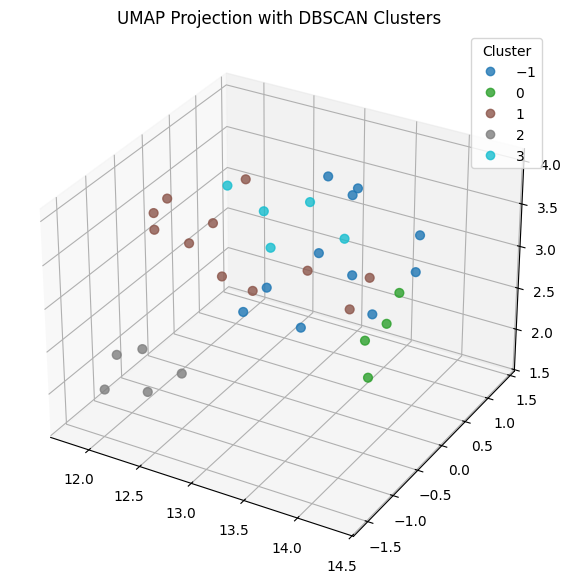

Cluster labels: [-1 -1  0  0 -1  1 -1  0  0  2  2  1  1  1 -1  3  2 -1  1  1  1 -1 -1  2
  2  1  1  3  3  3  3 -1 -1 -1  1  1]


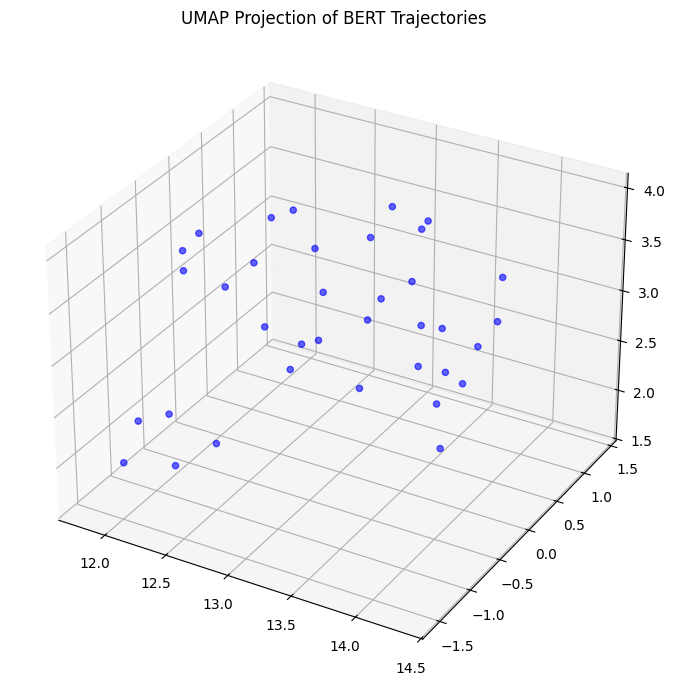

📊 Cluster labels: [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]


In [24]:
# 1. Flatten layerwise trajectories
data = np.stack(trajectories)                   # (N, 12, 768)
flat = data.reshape(data.shape[0], -1)          # (N, 9216)

# 2. UMAP to 3D
umap_3d = UMAP(n_components=3, random_state=42)
embedding = umap_3d.fit_transform(flat)

from sklearn.cluster import DBSCAN

# Try clustering with more lenient epsilon for UMAP space
dbscan = DBSCAN(eps=0.6, min_samples=3)  # Try 0.6–1.0
labels = dbscan.fit_predict(embedding)

# You must have `functions` list matching your sentences
from collections import defaultdict

functions = [
    # Descriptive (12)
    "descriptive", "descriptive", "descriptive", "descriptive",
    "descriptive", "descriptive", "descriptive", "descriptive",
    "descriptive", "descriptive", "descriptive", "descriptive",
    # Evaluative (12)
    "evaluative", "evaluative", "evaluative", "evaluative",
    "evaluative", "evaluative", "evaluative", "evaluative",
    "evaluative", "evaluative", "evaluative", "evaluative",
    # Narrative (12)
    "narrative", "narrative", "narrative", "narrative",
    "narrative", "narrative", "narrative", "narrative",
    "narrative", "narrative", "narrative", "narrative",
    # Performative (12)
    "performative", "performative", "performative", "performative",
    "performative", "performative", "performative", "performative",
    "performative", "performative", "performative", "performative"
]

cluster_map = defaultdict(list)
for i, label in enumerate(labels):
    if i < len(functions):  # Safety check
        cluster_map[label].append(functions[i])

# Print breakdown
for cid, roles in cluster_map.items():
    print(f"\n🧭 Cluster {cid}:")
    for role in sorted(set(roles)):
        count = roles.count(role)
        print(f"  {role}: {count} / {len(roles)}")

# Visualize clusters in UMAP 3D
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(embedding[:, 0], embedding[:, 1], embedding[:, 2],
                     c=labels, cmap='tab10', s=40, alpha=0.8)
plt.title("UMAP Projection with DBSCAN Clusters")
plt.legend(*scatter.legend_elements(), title="Cluster")
plt.show()

print("Cluster labels:", labels)

# 3. Visualize
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(embedding[:,0], embedding[:,1], embedding[:,2], c='blue', alpha=0.6)
ax.set_title("UMAP Projection of BERT Trajectories")
plt.tight_layout()
plt.show()

# Clustering
clustering = DBSCAN(eps=15.0, min_samples=2).fit(reduced)
labels = clustering.labels_
print("📊 Cluster labels:", labels)


In [21]:
df = pd.DataFrame({
    "Sentence": valid_sentences,
    "Cluster": labels
})
df.to_csv("trajectory_clusters_run.csv", index=False)
df.head()


,Sentence,Cluster
0,She likes to run early in the morning before w...,-1
1,The machine will run continuously for 48 hours.,-1
2,The river runs along the eastern border.,-1
3,This road runs all the way to the coast.,-1
4,Let the engine run for five minutes before sta...,-1
